### Get the data

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.rcParams['figure.figsize'] = [20, 20]
import numpy as np
import scipy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, 
                             precision_recall_curve, silhouette_samples, silhouette_score)
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
X_orig, y_orig = fetch_olivetti_faces(return_X_y=True)

In [3]:
X_train, X_rest, y_train, y_rest = train_test_split(X_orig, y_orig, train_size=0.7, shuffle=True, stratify=y_orig)

In [4]:
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.5, shuffle=True, stratify=y_rest)

### Explore the data

In [5]:
ks = list(range(2, 200))

In [6]:
%%time

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train)
                for k in ks]
inertias = [model.inertia_ for model in kmeans_per_k]

CPU times: user 3h 39min 57s, sys: 6min, total: 3h 45min 58s
Wall time: 7min 13s


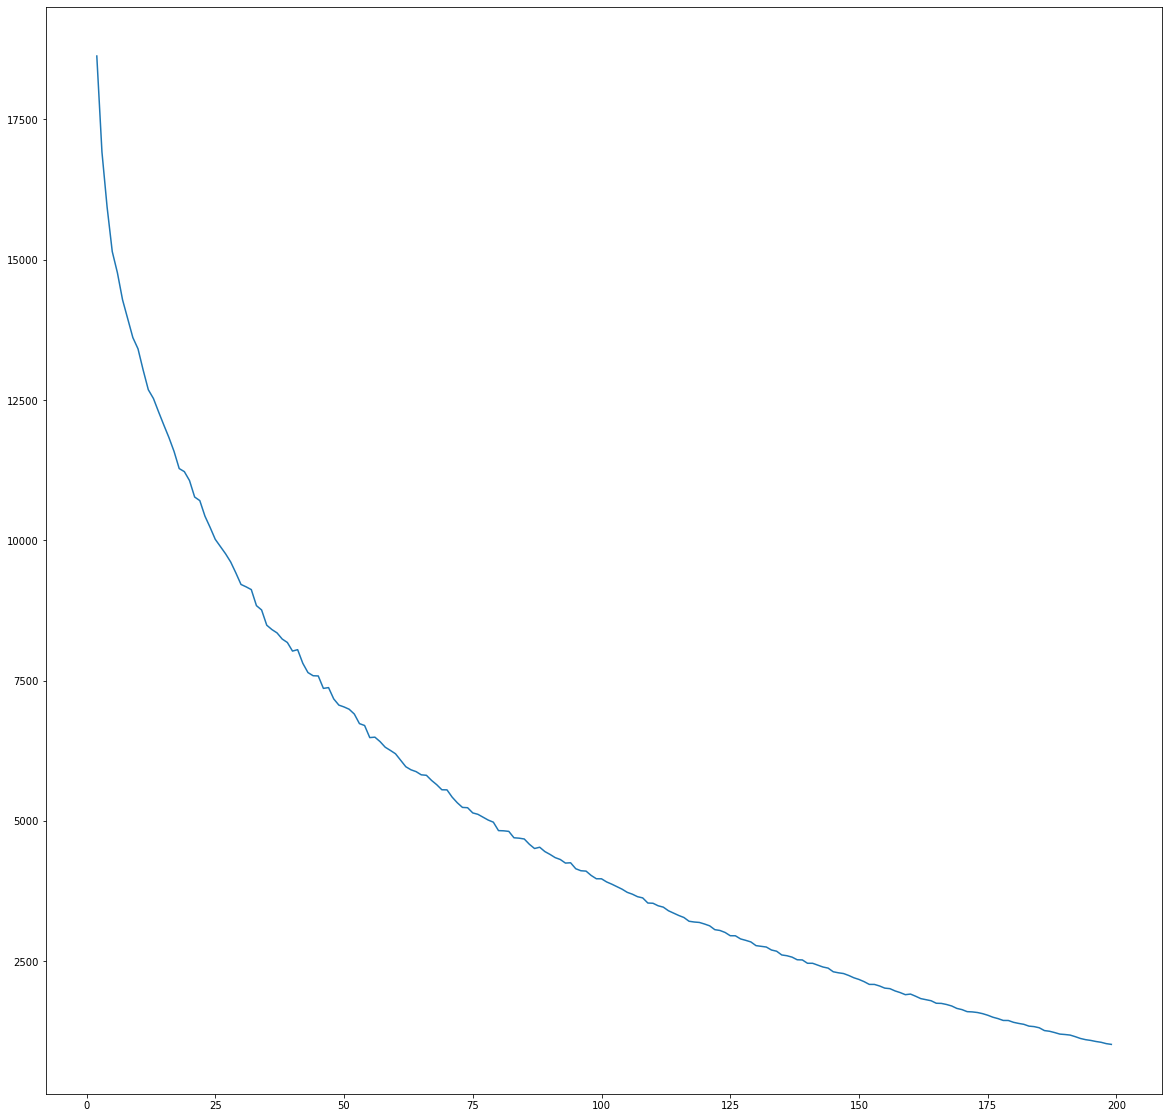

In [7]:
plt.plot(ks, inertias)

In [8]:
silhouette_scores = [silhouette_score(X_train, model.labels_)
                    for model in kmeans_per_k]

In [9]:
best_idx = np.argmax(np.array(silhouette_scores))
best_idx

91

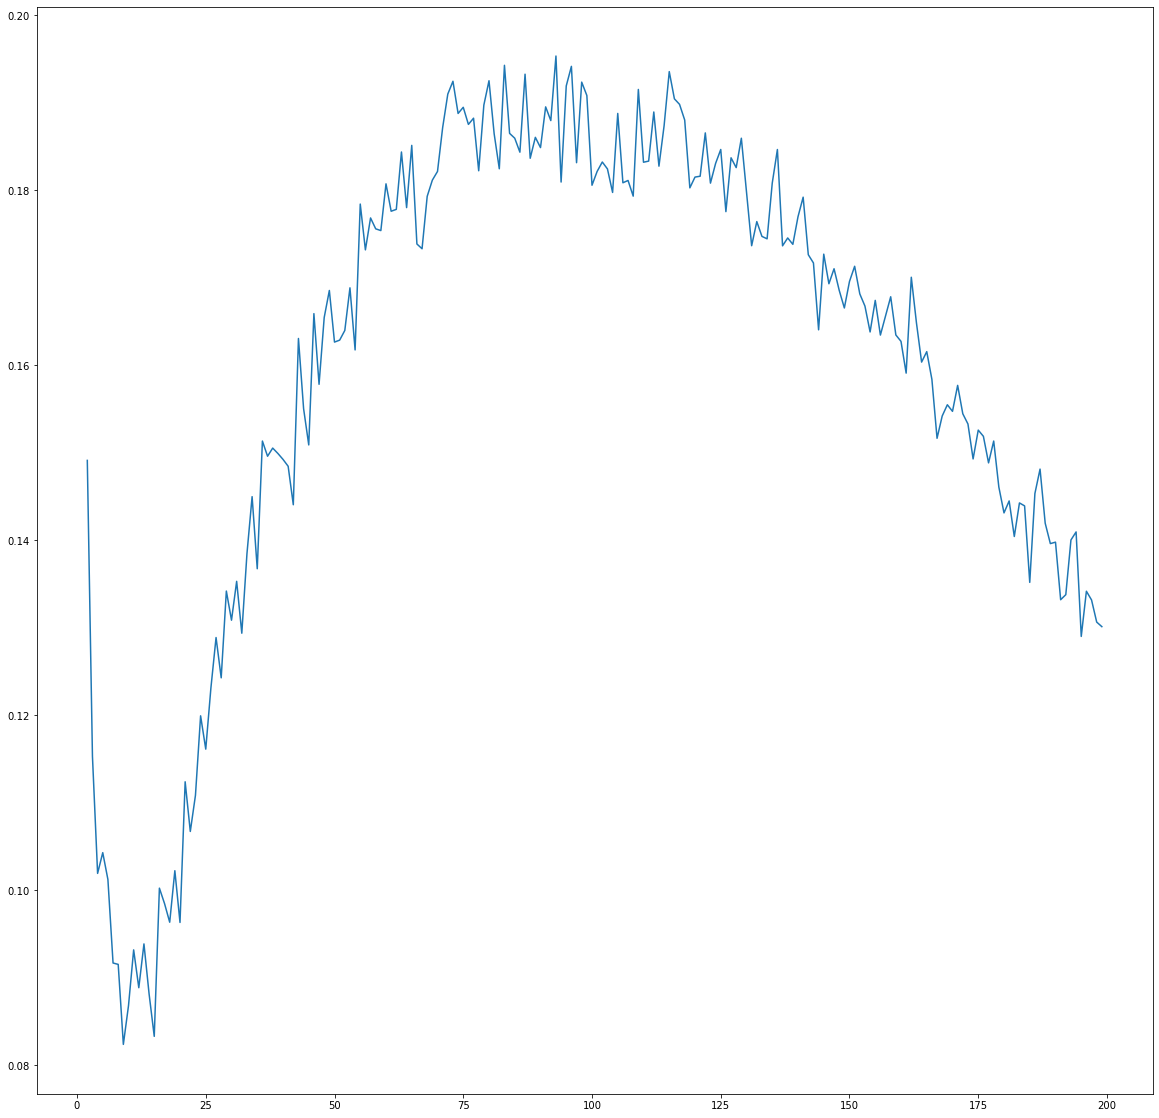

In [10]:
plt.plot(ks, silhouette_scores)

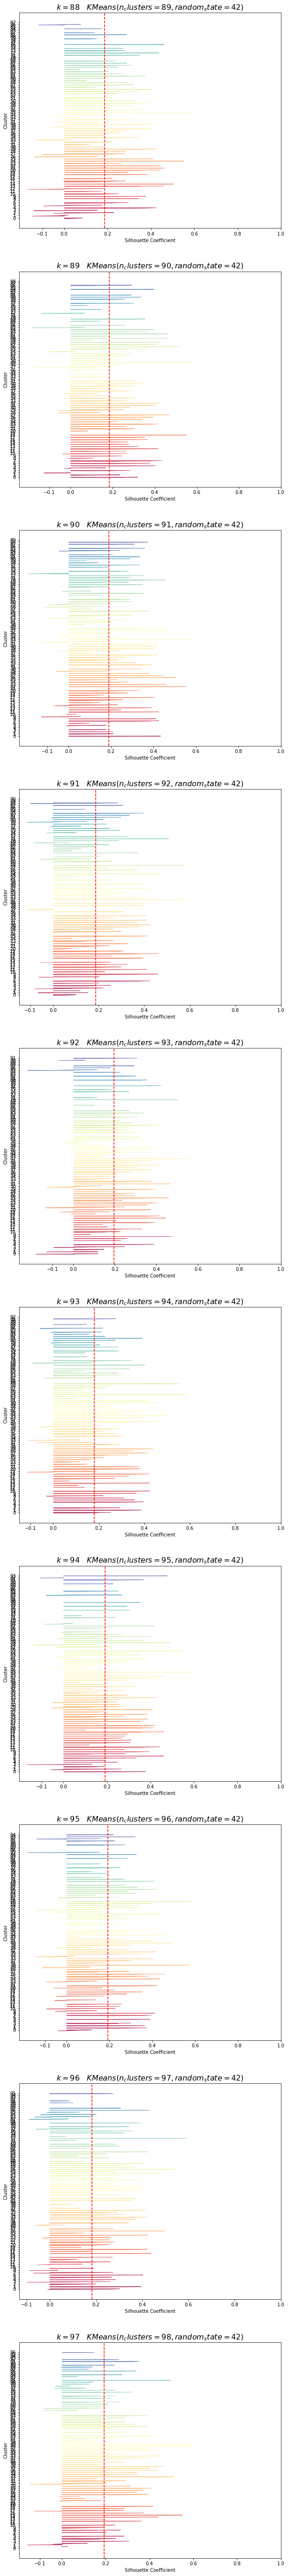

In [11]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb


plt.figure(figsize=(10, 100))
# offset = 75
# limit = 25
plot_ks = ks[best_idx-5:best_idx+5]

for idx, k in enumerate(plot_ks):
    plt.subplot(len(plot_ks), 1, idx+1)
    
    y_pred = kmeans_per_k[k].labels_
    silhouette_coefficients = silhouette_samples(X_train, y_pred)

    padding = len(X_train) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.ylabel("Cluster")
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Silhouette Coefficient")
    # else:
    #     plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={} \quad {}$".format(k, kmeans_per_k[k-1]), fontsize=16)

plt.show()

Let's spot check some clusters.

In [12]:
best_k_means = kmeans_per_k[best_idx+1]
best_k_means

KMeans(n_clusters=94, random_state=42)

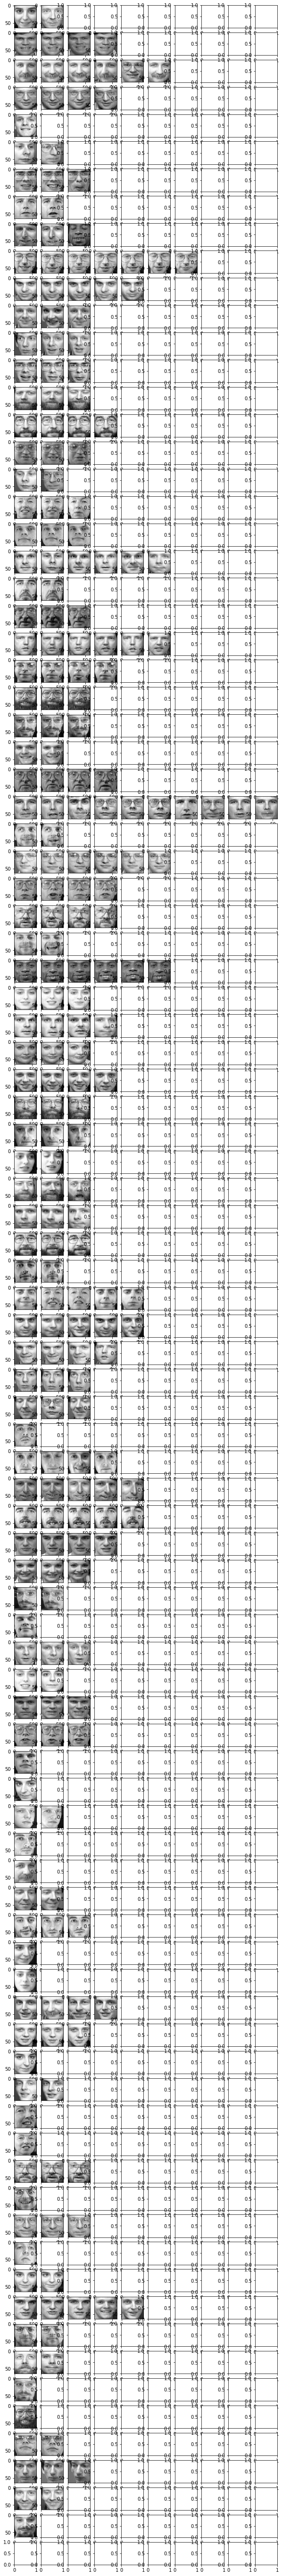

In [13]:
model = best_k_means
largest_cluster_size = np.bincount(model.labels_).max()
fig, ax = plt.subplots(model.n_clusters, largest_cluster_size, figsize=(10, 100))
for i in range(1, model.n_clusters+1):
    idx = model.labels_ == i
    cluster = X_train[idx]
    for j, img in enumerate(cluster):
        ax[i-1, j].imshow(img.reshape((64, 64)), cmap="gray")

On the other hand 6 clusters doesn't seem entirely unreasonable. This time I'll plot each cluster columnwise since the clusters will be much larger.

KMeans(n_clusters=6, random_state=42)


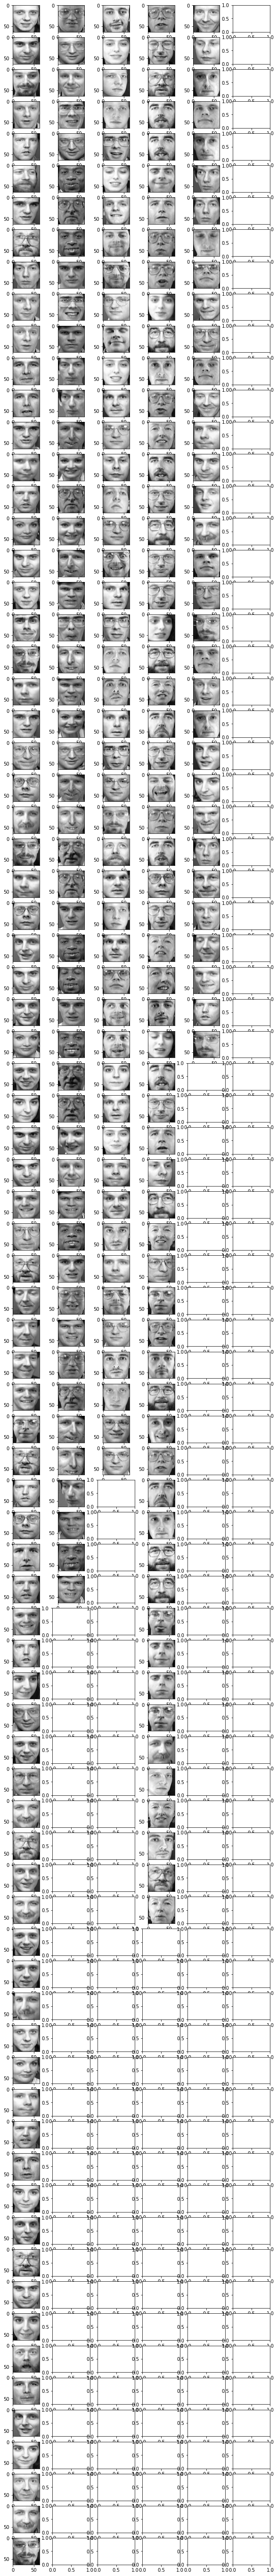

In [14]:
model = kmeans_per_k[4]
print(model)
largest_cluster_size = np.bincount(model.labels_).max()
fig, ax = plt.subplots(largest_cluster_size, model.n_clusters, figsize=(10, 100))
for i in range(1, model.n_clusters+1):
    idx = model.labels_ == i
    cluster = X_train[idx]
    for j, img in enumerate(cluster):
        ax[j, i-1].imshow(img.reshape((64, 64)), cmap="gray")

Not very compelling. What about 40 clusters since there are 40 different people? Clusters are row-wise this time.

KMeans(n_clusters=40, random_state=42)


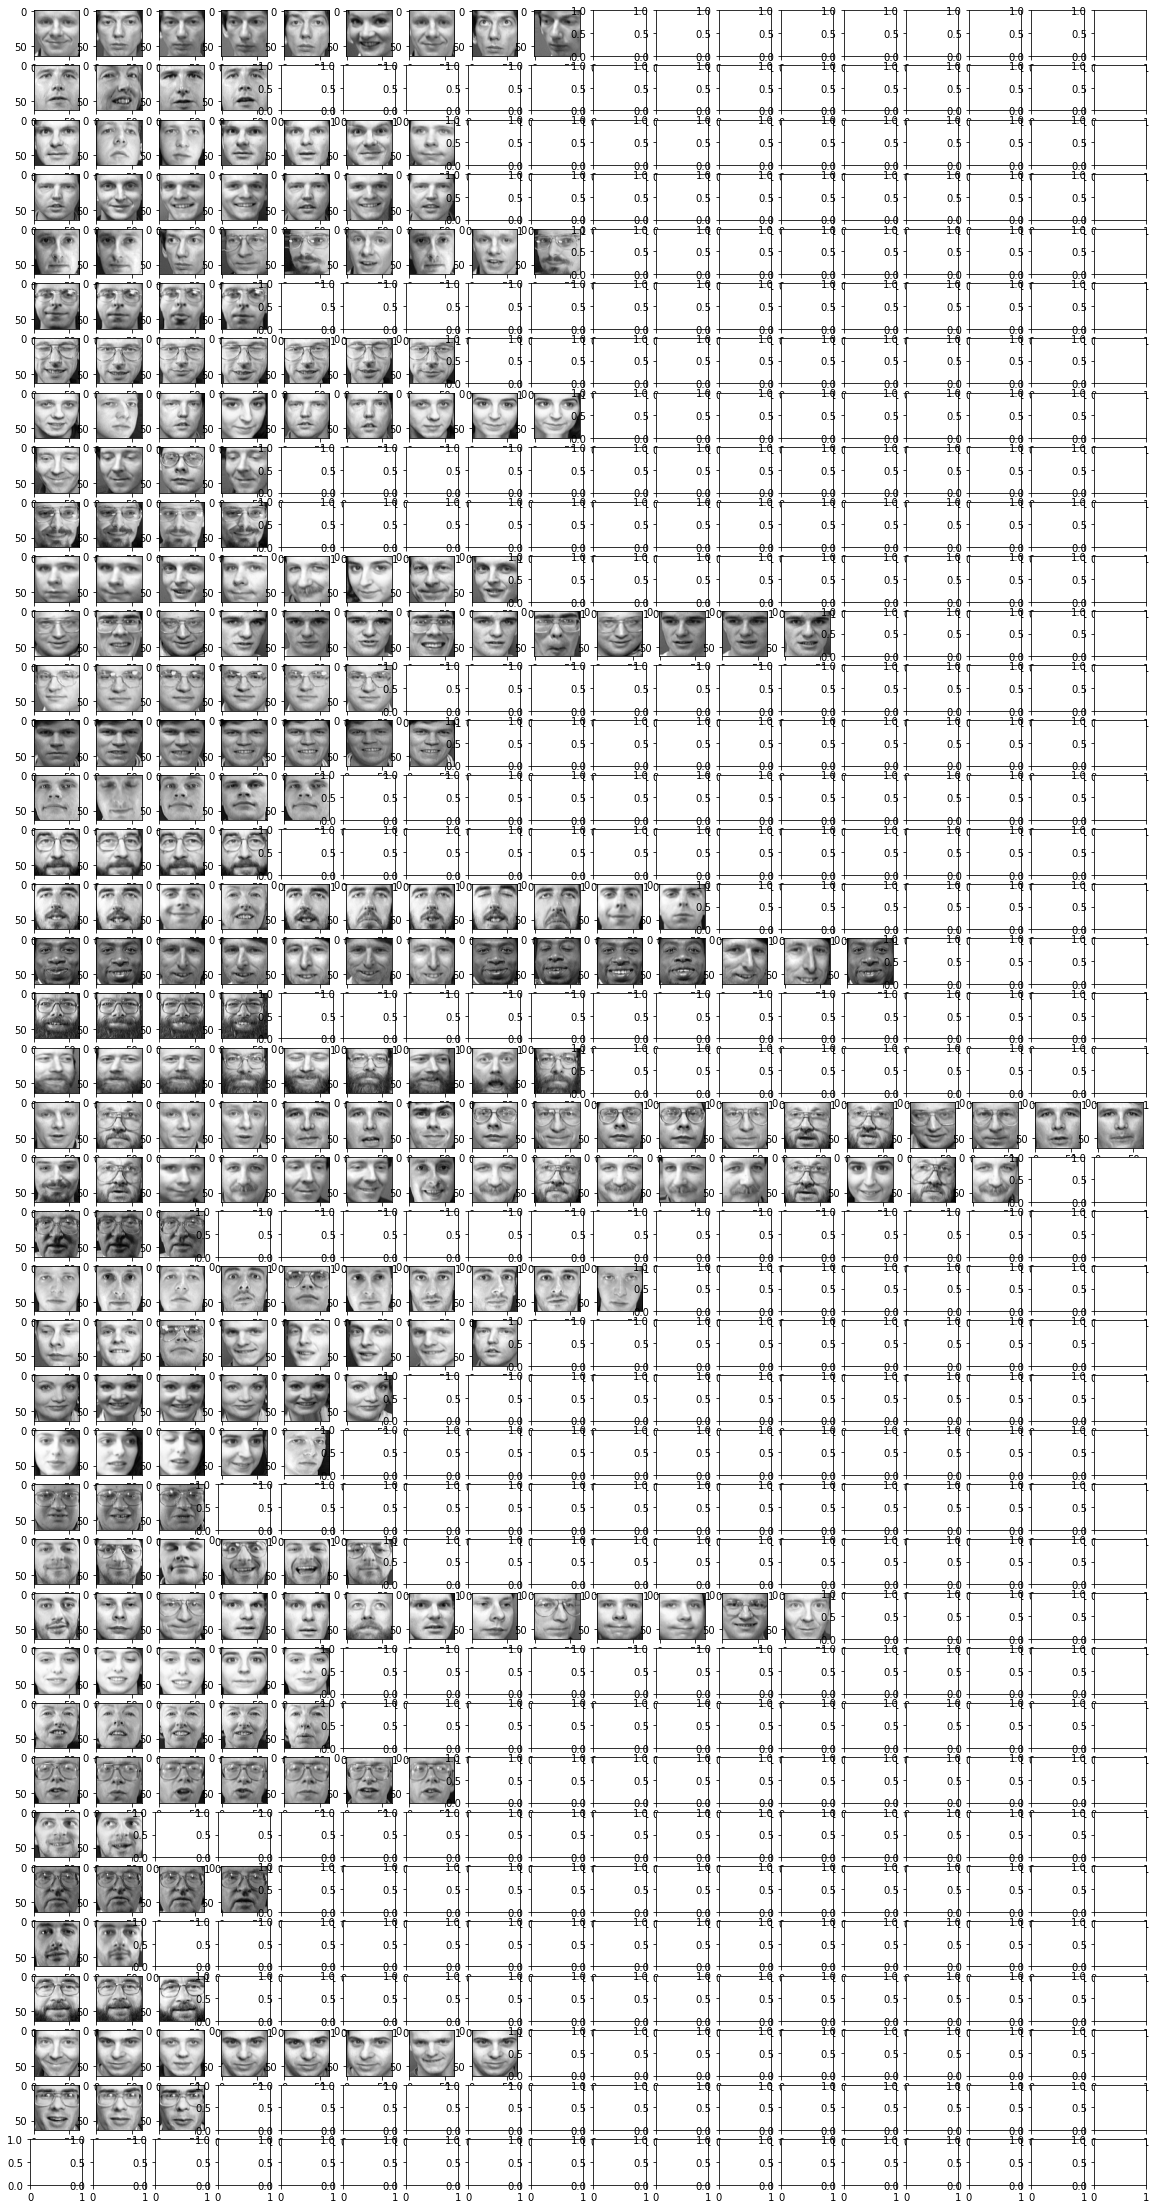

In [15]:
model = kmeans_per_k[38]
print(model)
largest_cluster_size = np.bincount(model.labels_).max()
fig, ax = plt.subplots(model.n_clusters, largest_cluster_size, figsize=(20, 40))
for i in range(1, model.n_clusters+1):
    idx = model.labels_ == i
    cluster = X_train[idx]
    for j, img in enumerate(cluster):
        ax[i-1, j].imshow(img.reshape((64, 64)), cmap="gray")

### Train a classifier

In [16]:
%%time

without_kmeans_pipeline = Pipeline([
    ("estimator", SVC()),
])

params = [
    {
        "estimator": [LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)],
        "estimator__C": scipy.stats.expon(scale=100),
    },
    {
        "estimator": [SVC()],
        "estimator__C": scipy.stats.expon(scale=100),
        "estimator__gamma": scipy.stats.expon(scale=0.1),
    },
    {
        "estimator": [RandomForestClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__max_features": [None, "sqrt", "log2"],
    },
    {
        "estimator": [GradientBoostingClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__learning_rate": scipy.stats.expon(scale=0.1),
    },
]

without_kmeans_clf = RandomizedSearchCV(
    without_kmeans_pipeline, 
    param_distributions=params,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1,
)
without_kmeans_search = without_kmeans_clf.fit(X_train, y_train)
print(f"best estimator {without_kmeans_search.best_estimator_}\nbest score {without_kmeans_search.best_score_}")

/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

best estimator Pipeline(steps=[('estimator',
                 LogisticRegression(C=93.533302064961, max_iter=500,
                                    multi_class='multinomial'))])
best score 0.9642857142857142
CPU times: user 2min 19s, sys: 3.27 s, total: 2min 22s
Wall time: 8min 58s


/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
%%time

with_kmeans_pipeline = Pipeline([
    ("kmeans", KMeans()),
    ("estimator", SVC()),
])

params = [
    {
        "estimator": [LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)],
        "estimator__C": scipy.stats.expon(scale=100),
        "kmeans__n_clusters": list(range(2, 150)),
    },
    {
        "estimator": [SVC()],
        "estimator__C": scipy.stats.expon(scale=100),
        "estimator__gamma": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 150)),
    },
    {
        "estimator": [RandomForestClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__max_features": [None, "sqrt", "log2"],
        "kmeans__n_clusters": list(range(2, 150)),
    },
    {
        "estimator": [GradientBoostingClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__learning_rate": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 150)),
    },
]

with_kmeans_clf = RandomizedSearchCV(
    with_kmeans_pipeline, 
    param_distributions=params,
    n_iter=300,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1,
)
with_kmeans_search = with_kmeans_clf.fit(X_train, y_train)
print(f"best estimator {with_kmeans_search.best_estimator_}\nbest score {with_kmeans_search.best_score_}")

/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

best estimator Pipeline(steps=[('kmeans', KMeans(n_clusters=144)),
                ('estimator',
                 LogisticRegression(C=12.408592938416962, max_iter=500,
                                    multi_class='multinomial'))])
best score 0.9285714285714286
CPU times: user 1min 59s, sys: 4.26 s, total: 2min 3s
Wall time: 14min 49s


/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
class KMeansConcatenator(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters)
        
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def transform(self, X):
        X_reduced = self.kmeans.transform(X)
        return np.c_[X, X_reduced]

In [19]:
%%time

with_kmeans_concatenator_pipeline = Pipeline([
    ("kmeans", KMeansConcatenator()),
    ("estimator", SVC()),
])

params = [
    {
        "estimator": [LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)],
        "estimator__C": scipy.stats.expon(scale=100),
        "kmeans__n_clusters": list(range(2, 150)),
    },
    {
        "estimator": [SVC()],
        "estimator__C": scipy.stats.expon(scale=100),
        "estimator__gamma": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 150)),
    },
    {
        "estimator": [RandomForestClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__max_features": [None, "sqrt", "log2"],
        "kmeans__n_clusters": list(range(2, 150)),
    },
    {
        "estimator": [GradientBoostingClassifier()],
        "estimator__n_estimators": [2**i for i in range(1, 9)],
        "estimator__max_depth": [None] + list(range(1, 10)),
        "estimator__learning_rate": scipy.stats.expon(scale=0.1),
        "kmeans__n_clusters": list(range(2, 150)),
    },
]

with_kmeans_concatenator_clf = RandomizedSearchCV(
    with_kmeans_concatenator_pipeline, 
    param_distributions=params,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1,
)
with_kmeans_concatenator_search = with_kmeans_concatenator_clf.fit(X_train, y_train)
print(f"best estimator {with_kmeans_concatenator_search.best_estimator_}\nbest score {with_kmeans_concatenator_search.best_score_}")

/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

best estimator Pipeline(steps=[('kmeans', KMeansConcatenator(n_clusters=50)),
                ('estimator',
                 LogisticRegression(C=56.55370667803366, max_iter=500,
                                    multi_class='multinomial'))])
best score 0.9499999999999998
CPU times: user 3min 1s, sys: 3.97 s, total: 3min 5s
Wall time: 21min 59s


/home/jon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
%%time

print(f"original X_train shape {X_train.shape}")
pca = PCA(n_components=.99)
X_train_reduced = pca.fit_transform(X_train)
print(f"X_train_reduced shape {X_train_reduced.shape}")
bgm = BayesianGaussianMixture(n_components=100, n_init=10)
bgm.fit(X_train_reduced, y_train)
print(f"weights: {bgm.weights_}")

    
    

original X_train shape (280, 4096)
X_train_reduced shape (280, 200)
weights: [0.01067583 0.00709171 0.0141324  0.02112152 0.00701443 0.02096507
 0.01740471 0.01387022 0.02763251 0.01376099 0.0171316  0.02047332
 0.01019365 0.00676697 0.02695272 0.02683451 0.02003482 0.00664736
 0.01323288 0.01317046 0.01638431 0.01630439 0.00973397 0.01614176
 0.01284719 0.01278028 0.01271266 0.01264432 0.01257523 0.00937903
 0.02487024 0.015453   0.00921629 0.01221391 0.00910389 0.01206266
 0.01198583 0.01190801 0.01182915 0.01468654 0.01458455 0.01158431
 0.01724964 0.01426581 0.01132349 0.00561646 0.01114233 0.00828769
 0.0109574  0.00814721 0.01076767 0.01067067 0.01057188 0.0052356
 0.0077779  0.01026887 0.01016515 0.01005927 0.00995112 0.01230071
 0.00729462 0.00720779 0.00949319 0.0117163  0.00924809 0.01367949
 0.00673767 0.00884538 0.0130541  0.00427504 0.00629807 0.00824195
 0.00808037 0.00395603 0.00387188 0.00568159 0.00370166 0.0054234
 0.00352743 0.0051589  0.00334879 0.00488745 0.0031652

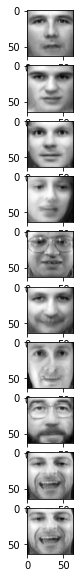

In [21]:
n_samples = 10
fig, ax = plt.subplots(n_samples, 1, figsize=(10, 10))
X_sample, y_sample = bgm.sample(n_samples)
X_reconstructed = pca.inverse_transform(X_sample)
for i, image in enumerate(X_reconstructed):
    ax[i].imshow(image.reshape((64, 64)), cmap="gray")

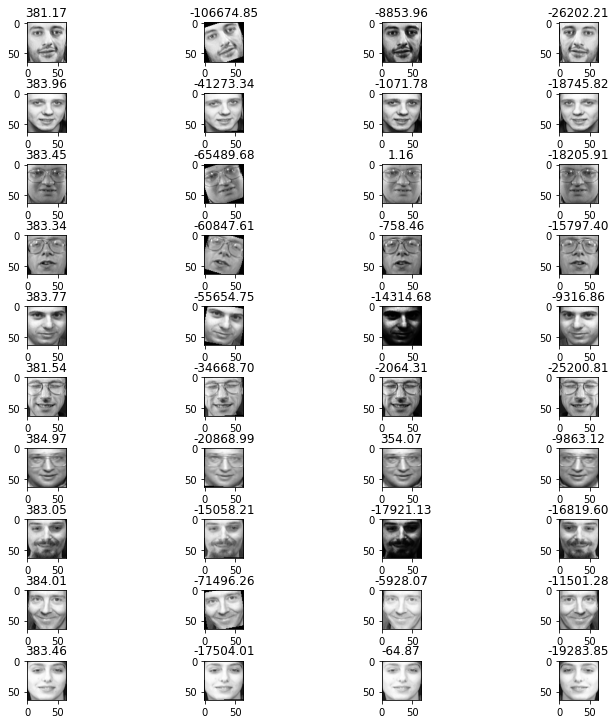

In [22]:
def score_image(image):
    reshaped = image.reshape(-1, 4096)
    projected = pca.transform(reshaped)
    return bgm.score_samples(projected)[0]

n_samples = 10
fig, ax = plt.subplots(n_samples, 4, figsize=(10, 10))
fig.tight_layout()
X_samples = X_train[:n_samples].reshape((-1, 64, 64))

# X_rotated = scipy.ndimage.rotate(X_samples.reshape(10, 64, 64), 1, reshape=False)
X_rotated = np.zeros(X_samples.shape)
X_rotation_angles = np.random.uniform(low=-20., high=20., size=n_samples)

X_darkened = np.zeros(X_samples.shape)
X_darkness_factor = np.random.uniform(low=0., high=5., size=n_samples)

X_flipped = np.zeros(X_samples.shape)

for i, (image, angle) in enumerate(zip(X_samples, X_rotation_angles)):
    X_rotated[i, :, :] = scipy.ndimage.rotate(image, angle, reshape=False)
    
for i, (image, factor) in enumerate(zip(X_samples, X_darkness_factor)):
    # There's probably a more sophisticated way to do this, but my idea is that since the pixels are in the range [0, 1], 
    # raising the pixel value to a power will reduce the size of the brightest pixels the most, and reduce the smallest-valued 
    # pixels the least, thus reducing the overall contrast of the image.
    X_darkened[i, :, :] = image**factor
    
for i, image in enumerate(X_samples):
    X_flipped[i, :, :] = np.fliplr(image)
    
for i, image_row in enumerate(zip(X_samples, X_rotated, X_darkened, X_flipped)):
    for j, image in enumerate(image_row):
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(f"{score_image(image):.2f}")

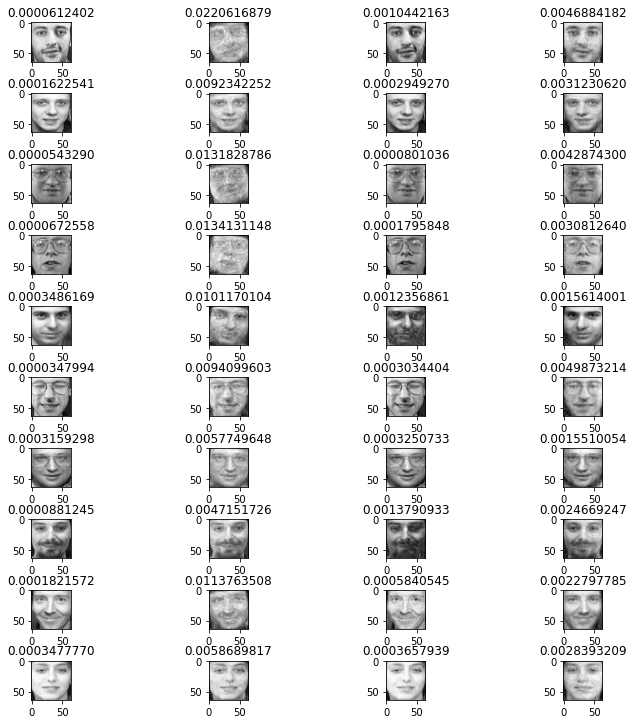

In [23]:
def reconstruct_with_error(image):
    reshaped = image.reshape(-1, 4096)
    projected = pca.transform(reshaped)
    reconstructed = pca.inverse_transform(projected)
    error = np.mean((reshaped - reconstructed)**2)
    return reconstructed.reshape((64, 64)), error

n_samples = 10
fig, ax = plt.subplots(n_samples, 4, figsize=(10, 10))
fig.tight_layout()

for i, image_row in enumerate(zip(X_samples, X_rotated, X_darkened, X_flipped)):
    for j, image in enumerate(image_row):
        reconstructed_image, error = reconstruct_with_error(image)
        ax[i, j].imshow(reconstructed_image, cmap="gray")
        ax[i, j].set_title(f"{error:.10f}")